# 📚 Document Chain Methods for RAG: A Comprehensive Tutorial

This notebook demonstrates different methods for combining retrieved documents to generate answers in RAG systems. Each method has its own strengths and use cases.

## 🔎 Overview of Methods

1. 📄 **Stuff Documents Chain** - Simple concatenation of all documents  
2. 🔄 **Refine Documents Chain** - Iterative refinement of answers  
3. 📊 **Map-Rerank Chain** - Score and rank individual document answers  
4. 🔀 **Map-Reduce Chain** - Summarize then combine approach  

Each method will be implemented using both ⚡ traditional LangChain and 🔧 modern LangGraph approaches.


## Setup and Imports


In [1]:
import json
import numpy as np
import warnings
from typing import Dict, List, Any, Literal, TypedDict, Annotated
import operator
from IPython.display import Image

# LangChain imports
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import LLMChain, RefineDocumentsChain, MapRerankDocumentsChain, MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.output_parsers.regex import RegexParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# LangGraph imports
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send

# Project imports
from retrieval_playground.utils import config
from retrieval_playground.src.baseline_rag import RAG
from retrieval_playground.src.evaluation import RAGEvaluator
from retrieval_playground.src.pre_retrieval.chunking_strategies import ChunkingStrategy

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


## Load Test Data and Initialize Components


In [2]:
def load_test_queries() -> List[Dict[str, Any]]:
    """Load test queries from JSON file."""
    queries_path = config.TESTS_DIR / "test_queries.json"
    with open(queries_path, 'r') as f:
        return json.load(f)

# Initialize RAG system and evaluator
strategy = ChunkingStrategy.UNSTRUCTURED
rag = RAG(strategy=strategy)
evaluator = RAGEvaluator(metrics=['faithfulness', 'answer_relevancy'])


# Load test queries (using first 2 for demo)
test_queries = load_test_queries()[:3]
ground_truths = [q["reference"] for q in test_queries]

print(f"Sample query: {test_queries[0]['user_input']}")
print(f"Number of test queries: {len(test_queries)}")


2025-09-16 18:10:37.516 INFO model_manager - _initialize_models: 🔄 ModelManager: Initializing shared AI models...
2025-09-16 18:10:44.839 INFO model_manager - _initialize_models: ✅ ModelManager: Shared AI models initialized successfully
2025-09-16 18:10:45.849 INFO baseline_rag - __init__: ✅ BaselineRAG pipeline initialized
2025-09-16 18:10:45.850 INFO evaluation - __init__: ✅ RAGEvaluator initialized with metrics: ['faithfulness', 'answer_relevancy']
Sample query: How does MC3G improve upon existing counterfactual explanation methods, particularly concerning cost computation and causal dependencies?
Number of test queries: 3


## Evaluation Helper Function


In [3]:
def evaluate_method(method_name: str, rag_results: List[Dict], ground_truths: List[str]):
    """Helper function to evaluate and display results for any method."""
    print(f"\n=== {method_name} Results ===")
    
    # Show sample answer
    print(f"Sample Answer: {rag_results[0]['answer'][:200]}...")
    
    # Evaluate with RAGAS metrics
    scores = evaluator.evaluate_rag_results(rag_results, ground_truths)
    
    # Display metrics
    print(f"Average Faithfulness: {np.round(np.nanmean(scores['faithfulness']), 2)}")
    print(f"Average Answer Relevancy: {np.round(np.nanmean(scores['answer_relevancy']), 2)}")
    
    return scores


## 📄 Method 1: Stuff Documents Chain

**🔎 What it is:** Simply concatenates all retrieved documents and passes them to the LLM in a single prompt.

**🎯 When to use:**
- Small number of documents that fit within context window
- When you want the LLM to consider all information simultaneously
- Fastest and simplest approach

**🌟 Pros:** Simple, fast, considers all context at once <br>
**⚠️ Cons:** Limited by context window, may overwhelm LLM with too much information


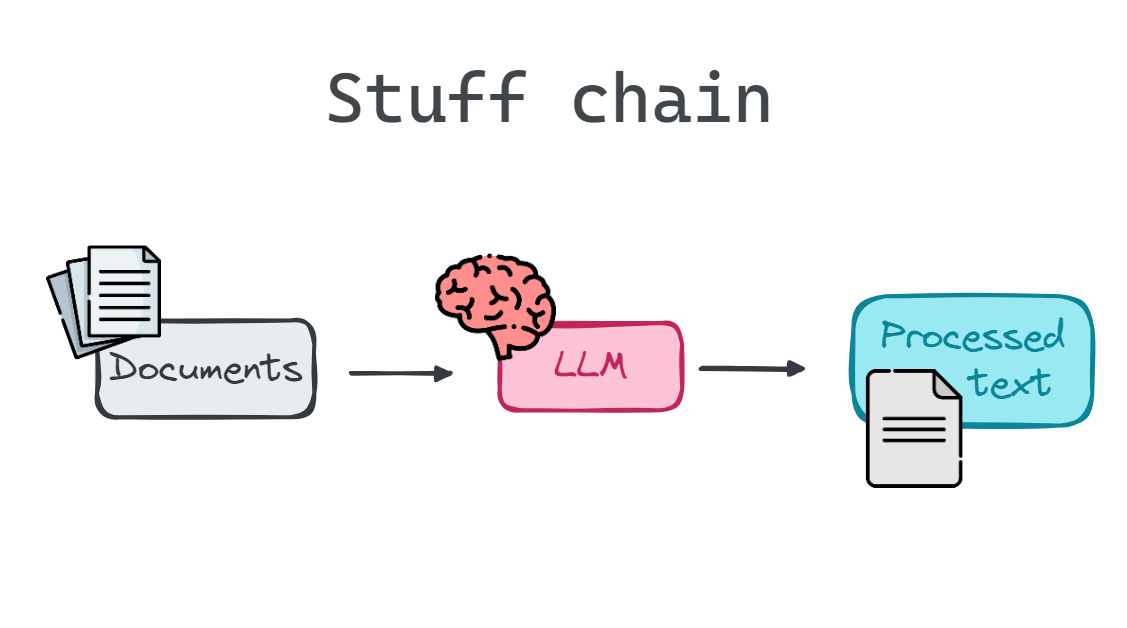

In [4]:
from IPython.display import Image, display
display(Image(filename="../../utils/images/stuff.png"))

In [5]:
# Traditional LangChain approach
stuff_prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant that answers questions based on the provided context.
    Please provide a comprehensive answer based on the context below. 
    If the context doesn't contain enough information to answer the question, please say so.

    Question: {question} 

    Context:
    {context}

    Answer:"""
)

stuff_chain = create_stuff_documents_chain(rag.llm, stuff_prompt)

# Test the method
stuff_results = []
for test_query in test_queries:
    query = test_query["user_input"]
    docs = [doc[0] for doc in rag.retrieve_context(query)]
    result = stuff_chain.invoke({"context": docs, "question": query})
    stuff_results.append({
        "question": query, 
        "answer": result, 
        "context": [{"content": doc.page_content} for doc in docs]
    })

# Evaluate
stuff_scores = evaluate_method("Stuff Documents Chain", stuff_results, ground_truths)


=== Stuff Documents Chain Results ===
Sample Answer: MC3G improves upon existing counterfactual explanation methods like C3G in two key ways: cost computation and handling causal dependencies.

**Cost Computation:**  Existing methods (e.g., C3G, MACE) a...
2025-09-16 18:10:56.837 INFO evaluation - evaluate_batch: 🔄 Evaluating 3 QA pairs...
2025-09-16 18:10:56.851 INFO evaluation - evaluate_batch: 🧮 Computing RAGAS metrics...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

2025-09-16 18:11:35.612 INFO evaluation - evaluate_batch: ✅ Evaluation completed
Average Faithfulness: 1.0
Average Answer Relevancy: 0.95


In [6]:
del stuff_prompt, stuff_results#, stuff_chain

## 🔄 Method 2: Refine Documents Chain

**🔎 What it is:** Processes documents sequentially, starting with an initial answer from the first document, then refining it with each subsequent document.

**🎯 When to use:**
- When you have many documents that don't fit in context window
- When you want iterative improvement of answers
- When document order matters

**🌟 Pros:** Handles large document sets, iterative refinement, maintains context <br>
**⚠️ Cons:** Slower (multiple LLM calls), order-dependent, potential information loss


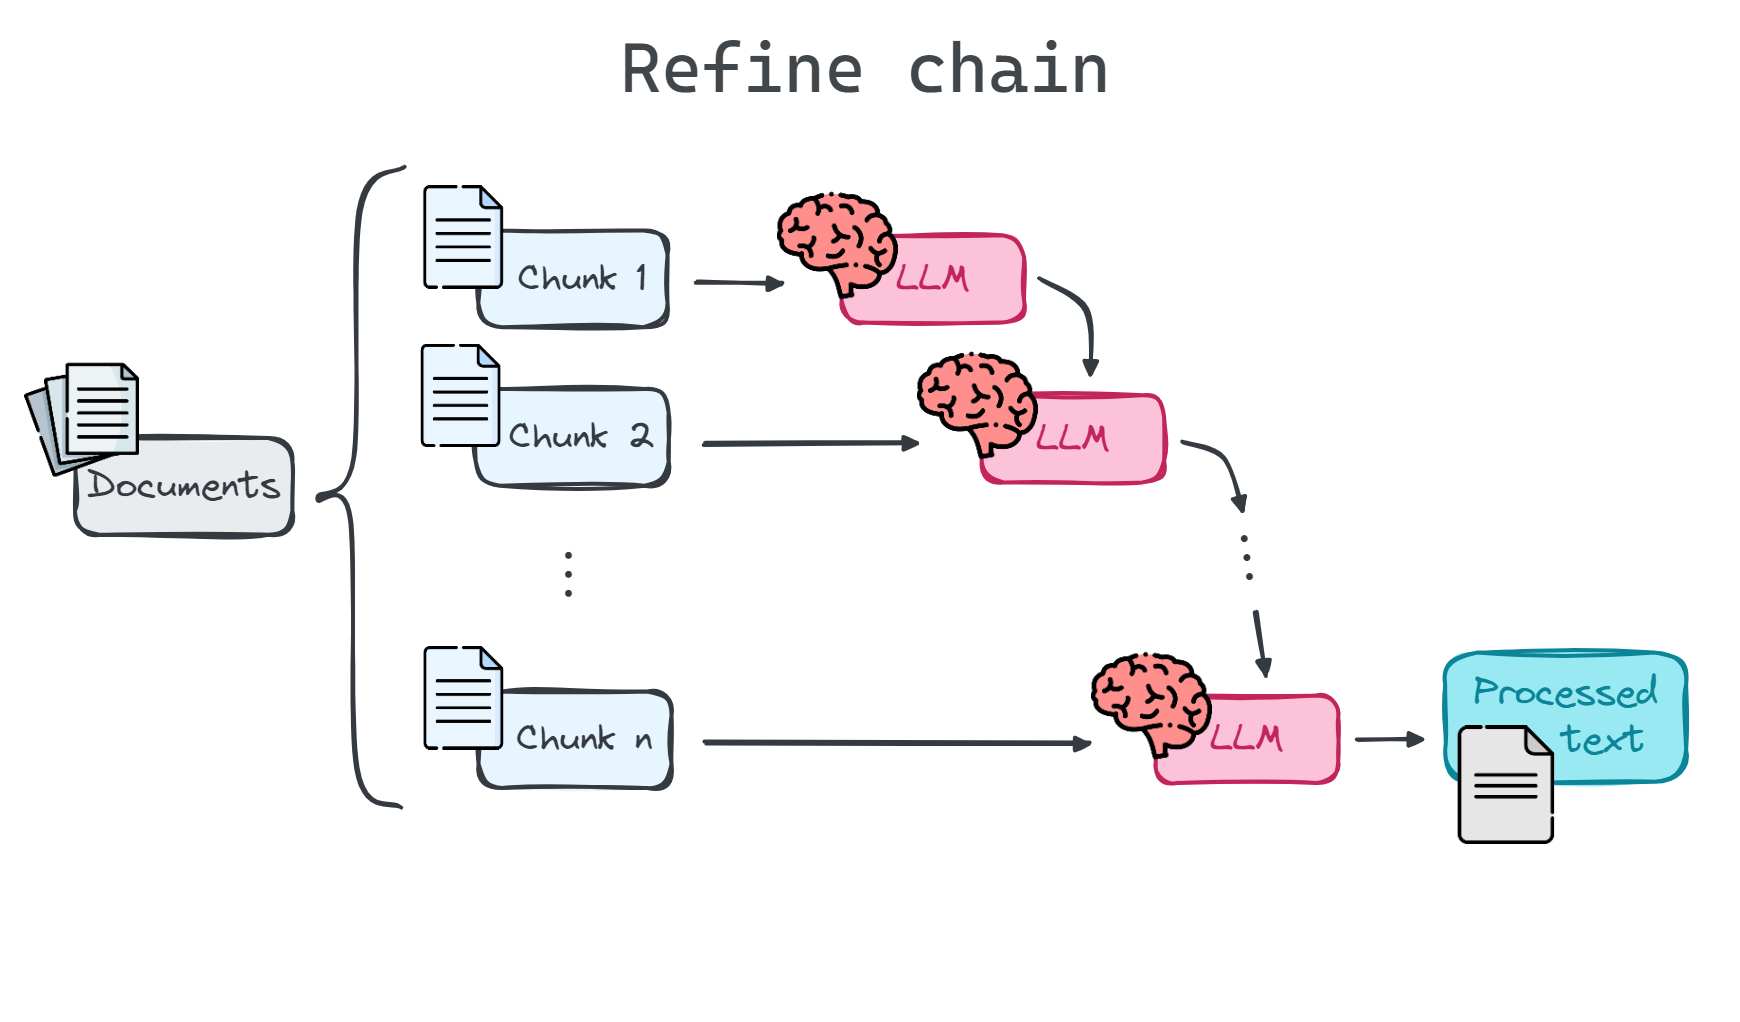

In [7]:
from IPython.display import Image, display
display(Image(filename="../../utils/images/refine.png"))

In [8]:
# Traditional LangChain approach
document_prompt = PromptTemplate(
    input_variables=["page_content"], template="{page_content}"
)

# Initial summarization prompt
summarize_prompt = ChatPromptTemplate.from_messages([
    ("human", 
    """You are a helpful assistant that answers questions based on the given context.

    Question: {question}

    Context:
    {context}

    Provide the best possible answer based on this context:""")
])
initial_llm_chain = LLMChain(llm=rag.llm, prompt=summarize_prompt)

# Refinement prompt
refine_template = """
We have an existing answer so far:
{existing_answer}

Here is some new context:
------------
{context}
------------

Refine the existing answer where needed, keeping it accurate and comprehensive.
If the new context is not useful, keep the answer unchanged.
"""
refine_prompt = ChatPromptTemplate.from_messages([("human", refine_template)])
refine_llm_chain = LLMChain(llm=rag.llm, prompt=refine_prompt)

# Build the refine chain
refine_chain = RefineDocumentsChain(
    initial_llm_chain=initial_llm_chain,
    refine_llm_chain=refine_llm_chain,
    document_prompt=document_prompt,
    document_variable_name="context",
    initial_response_name="existing_answer",
)

# Test the method
refine_results = []
for test_query in test_queries:
    query = test_query["user_input"]
    docs = [doc[0] for doc in rag.retrieve_context(query)]
    result = refine_chain.invoke({"input_documents": docs, "question": query})["output_text"]
    refine_results.append({
        "question": query, 
        "answer": result, 
        "context": [{"content": doc.page_content} for doc in docs]
    })

# Evaluate
refine_scores = evaluate_method("Refine Documents Chain", refine_results, ground_truths)


=== Refine Documents Chain Results ===
Sample Answer: MC3G (Model-Agnostic Causally Constrained Counterfactual Generation) is a novel method for generating counterfactual explanations that addresses limitations of existing techniques like C3G, MACE, and ...
2025-09-16 18:12:59.554 INFO evaluation - evaluate_batch: 🔄 Evaluating 3 QA pairs...
2025-09-16 18:12:59.560 INFO evaluation - evaluate_batch: 🧮 Computing RAGAS metrics...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

2025-09-16 18:14:00.630 INFO evaluation - evaluate_batch: ✅ Evaluation completed
Average Faithfulness: 0.92
Average Answer Relevancy: 0.86


In [9]:
del document_prompt, summarize_prompt, initial_llm_chain, refine_template, refine_llm_chain, refine_results#, refine_chain

### 🔧 Refine Chain - LangGraph Implementation

Implementation using LangGraph for better control and visualization.



=== Testing LangGraph Refine Implementation ===
LangGraph Result: MC3G improves upon existing counterfactual explanation methods like C3G and MACE by addressing three key limitations:

1. **Accurate Cost Computation:**  Unlike C3G and MACE, which assign costs to all...


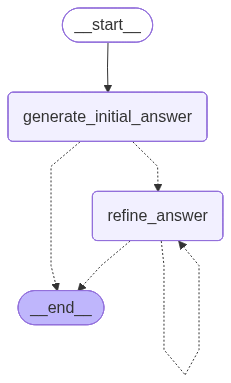

In [10]:
# LangGraph implementation
initial_prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant that answers questions based on the given context.

Question: {question}

Context:
{context}

Provide the best possible answer based on this context."""
)
initial_chain = initial_prompt | rag.llm | StrOutputParser()

refine_prompt_lg = ChatPromptTemplate.from_template(
    """We have an existing answer so far:
{existing_answer}

Here is some new context:
------------
{context}
------------

Refine the existing answer where needed, keeping it accurate and comprehensive.
If the new context is not useful, keep the answer unchanged."""
)
refine_chain_lg = refine_prompt_lg | rag.llm | StrOutputParser()

# State definition
class RefineState(TypedDict):
    question: str
    docs: List[str]
    index: int
    answer: str

# Graph nodes
def generate_initial_answer(state: RefineState):
    """Generate the first answer from the first document."""
    first_doc = state["docs"][0]
    answer = initial_chain.invoke({"question": state["question"], "context": first_doc})
    return {"answer": answer, "index": 1}

def refine_answer(state: RefineState):
    """Refine answer with the next document."""
    doc = state["docs"][state["index"]]
    refined = refine_chain_lg.invoke(
        {"existing_answer": state["answer"], "context": doc}
    )
    return {"answer": refined, "index": state["index"] + 1}

# Routing logic
def should_refine(state: RefineState) -> Literal["refine_answer", END]:
    if state["index"] >= len(state["docs"]):
        return END
    else:
        return "refine_answer"

# Build LangGraph
refine_graph = StateGraph(RefineState)
refine_graph.add_node("generate_initial_answer", generate_initial_answer)
refine_graph.add_node("refine_answer", refine_answer)

refine_graph.add_edge(START, "generate_initial_answer")
refine_graph.add_conditional_edges("generate_initial_answer", should_refine)
refine_graph.add_conditional_edges("refine_answer", should_refine)

refine_app = refine_graph.compile()

# Test LangGraph implementation
print("\n=== Testing LangGraph Refine Implementation ===")
query = test_queries[0]["user_input"]
docs = [doc[0].page_content for doc in rag.retrieve_context(query)]

final_state = refine_app.invoke({"question": query, "docs": docs, "index": 0})
print(f"LangGraph Result: {final_state['answer'][:200]}...")
Image(refine_app.get_graph().draw_mermaid_png())

In [11]:
del initial_prompt, initial_chain, refine_prompt_lg, refine_chain_lg, refine_graph, refine_app, docs, final_state

## 📊 Method 3: Map-Rerank Chain

**🔎 What it is:** Processes each document independently to generate answers with confidence scores, then selects the highest-scoring answer.

**🎯 When to use:**
- When you want to identify the most relevant document
- When documents might contain conflicting information
- When you need confidence scores for answers

**🌟 Pros:** Parallel processing, confidence scoring, handles conflicting information <br>
**⚠️ Cons:** Only uses one document's information, may miss connections between documents


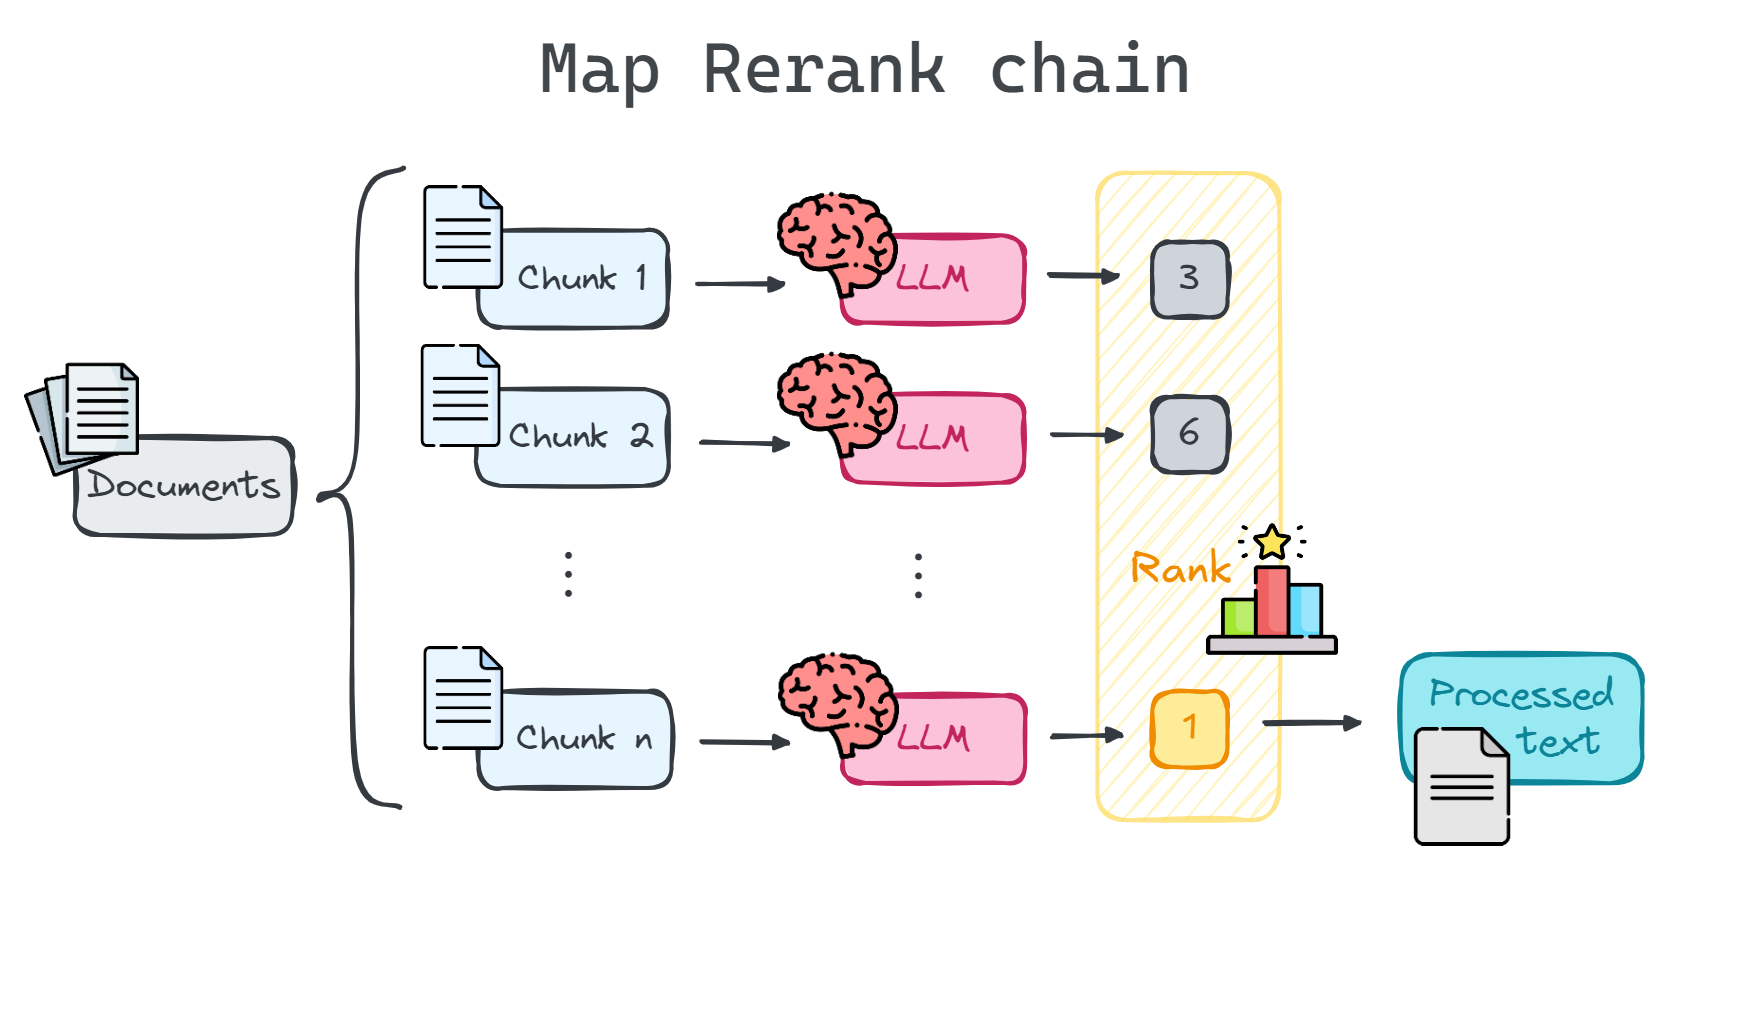

In [12]:
from IPython.display import Image, display
display(Image(filename="../../utils/images/map_rerank.png"))

In [33]:
# Traditional LangChain approach
prompt_template = """
You are a helpful assistant. 
Answer the following question using ONLY the given context. 
If the context does not contain the answer, say "Not enough information."

Question: {question}

Context:
{context}

Provide your answer and a confidence score (1-10) in this format:
<Answer>
Score: <Score>
"""

# Parser for extracting answer and score
output_parser = RegexParser(
    regex=r"(?s)(.*?)\n+Score:\s*([0-9]+)",
    output_keys=["answer", "score"],
)

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"],
    output_parser=output_parser,
)

llm_chain = LLMChain(llm=rag.llm, prompt=prompt)

# Rerank chain
rerank_chain = MapRerankDocumentsChain(
    llm_chain=llm_chain,
    document_variable_name="context",
    rank_key="score",
    answer_key="answer",
)

# Test the method
rerank_results = []
for test_query in test_queries:
    query = test_query["user_input"]
    docs = [doc[0] for doc in rag.retrieve_context(query)]
    result = rerank_chain.invoke({"input_documents": docs, "question": query})["output_text"]
    rerank_results.append({
        "question": query, 
        "answer": result, 
        "context": [{"content": doc.page_content} for doc in docs]
    })

# Evaluate
rerank_scores = evaluate_method("Map-Rerank Chain", rerank_results, ground_truths)


=== Map-Rerank Chain Results ===
Sample Answer: MC3G improves upon existing methods (C3G, MACE) by refining cost computation to distinguish between direct interventions and causal effects.  It excludes automatically occurring changes due to causal ...
2025-09-16 18:41:24.755 INFO evaluation - evaluate_batch: 🔄 Evaluating 3 QA pairs...
2025-09-16 18:41:24.767 INFO evaluation - evaluate_batch: 🧮 Computing RAGAS metrics...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

2025-09-16 18:41:53.058 INFO evaluation - evaluate_batch: ✅ Evaluation completed
Average Faithfulness: 1.0
Average Answer Relevancy: 0.9


In [34]:
del prompt_template, output_parser, prompt, llm_chain, rerank_results#, rerank_chain

### 🔧 Rerank Chain - LangGraph Implementation

Implementation using LangGraph for better control and visualization.


=== Testing LangGraph Rerank Implementation ===
LangGraph Result: {'answer': 'MC3G improves upon existing methods by correctly accounting for causal dependencies, treating causally induced changes as cost-free.  In contrast, C3G incorrectly assigns a cost to all feature modifications, even those that occur naturally. This results in MC3G consistently producing closer counterfactuals than C3G across various metrics and norms (L1 and L2).', 'score': 10.0}...


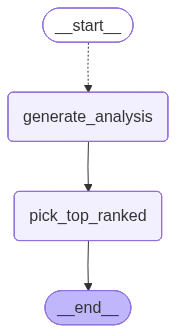

In [15]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.types import Send  # Updated import
from langgraph.graph import END, START, StateGraph

# --- LLM & Prompt ---
class AnswerWithScore(TypedDict):
    answer: str
    score: Annotated[int, ..., "Score from 1-10."]

prompt_template = """
You are a helpful assistant. 
Answer the following question using ONLY the given context. 
If the context does not contain the answer, say "Not enough information."

Question: {question}

Context:
{context}

Provide your answer and a confidence score (1-10) in this format:
<Answer>
Score: <Score>
"""

prompt = ChatPromptTemplate.from_template(prompt_template)

# Chain that generates AnswerWithScore
map_chain = prompt | rag.llm.with_structured_output(AnswerWithScore)

# --- State definitions ---
class State(TypedDict):
    contents: List[str]
    question: str                      
    answers_with_scores: Annotated[list, operator.add]
    answer: str
    
class MapState(TypedDict):
    content: str
    question: str

# --- Map function: generate a node for each document ---
def map_analyses(state: State):
    return [
        Send("generate_analysis", {"content": content, "question": state["question"]})
        for content in state["contents"]
    ]

# --- Generate answer + score for a document ---
def generate_analysis(state: MapState):
    response = map_chain.invoke({
        "context": state["content"], 
        "question": state["question"]
    })
    return {"answers_with_scores": [response]}

# --- Pick top-ranked answer ---
def pick_top_ranked(state: State):
    ranked_answers = sorted(
        state["answers_with_scores"], key=lambda x: -int(x["score"])
    )
    return {"answer": ranked_answers[0]}

# --- Construct the graph ---
rerank_graph = StateGraph(State)
rerank_graph.add_node("generate_analysis", generate_analysis)
rerank_graph.add_node("pick_top_ranked", pick_top_ranked)
rerank_graph.add_conditional_edges(START, map_analyses, ["generate_analysis"])
rerank_graph.add_edge("generate_analysis", "pick_top_ranked")
rerank_graph.add_edge("pick_top_ranked", END)

rerank_app = rerank_graph.compile()

# Test LangGraph implementation
print("\n=== Testing LangGraph Rerank Implementation ===")
query = test_queries[0]["user_input"]
docs = [doc[0].page_content for doc in rag.retrieve_context(query)]

result = rerank_app.invoke({"contents": docs, "question": query})
print(f"LangGraph Result: {result['answer']}...")

Image(rerank_app.get_graph().draw_mermaid_png())

In [16]:
del prompt_template, prompt, map_chain, rerank_graph, rerank_app, docs, result

## 🔀 Method 4: Map-Reduce Chain

**🔎 What it is:** First maps (summarizes) each document independently, then reduces (combines) all summaries to generate a final answer.

**🎯 When to use:**
- Large number of documents that exceed context window
- When you want to consider information from all documents
- When documents contain complementary information

**🌟 Pros:** Handles large document sets, parallel processing, considers all information
**⚠️ Cons:** Two-step process (slower), potential information loss in summarization


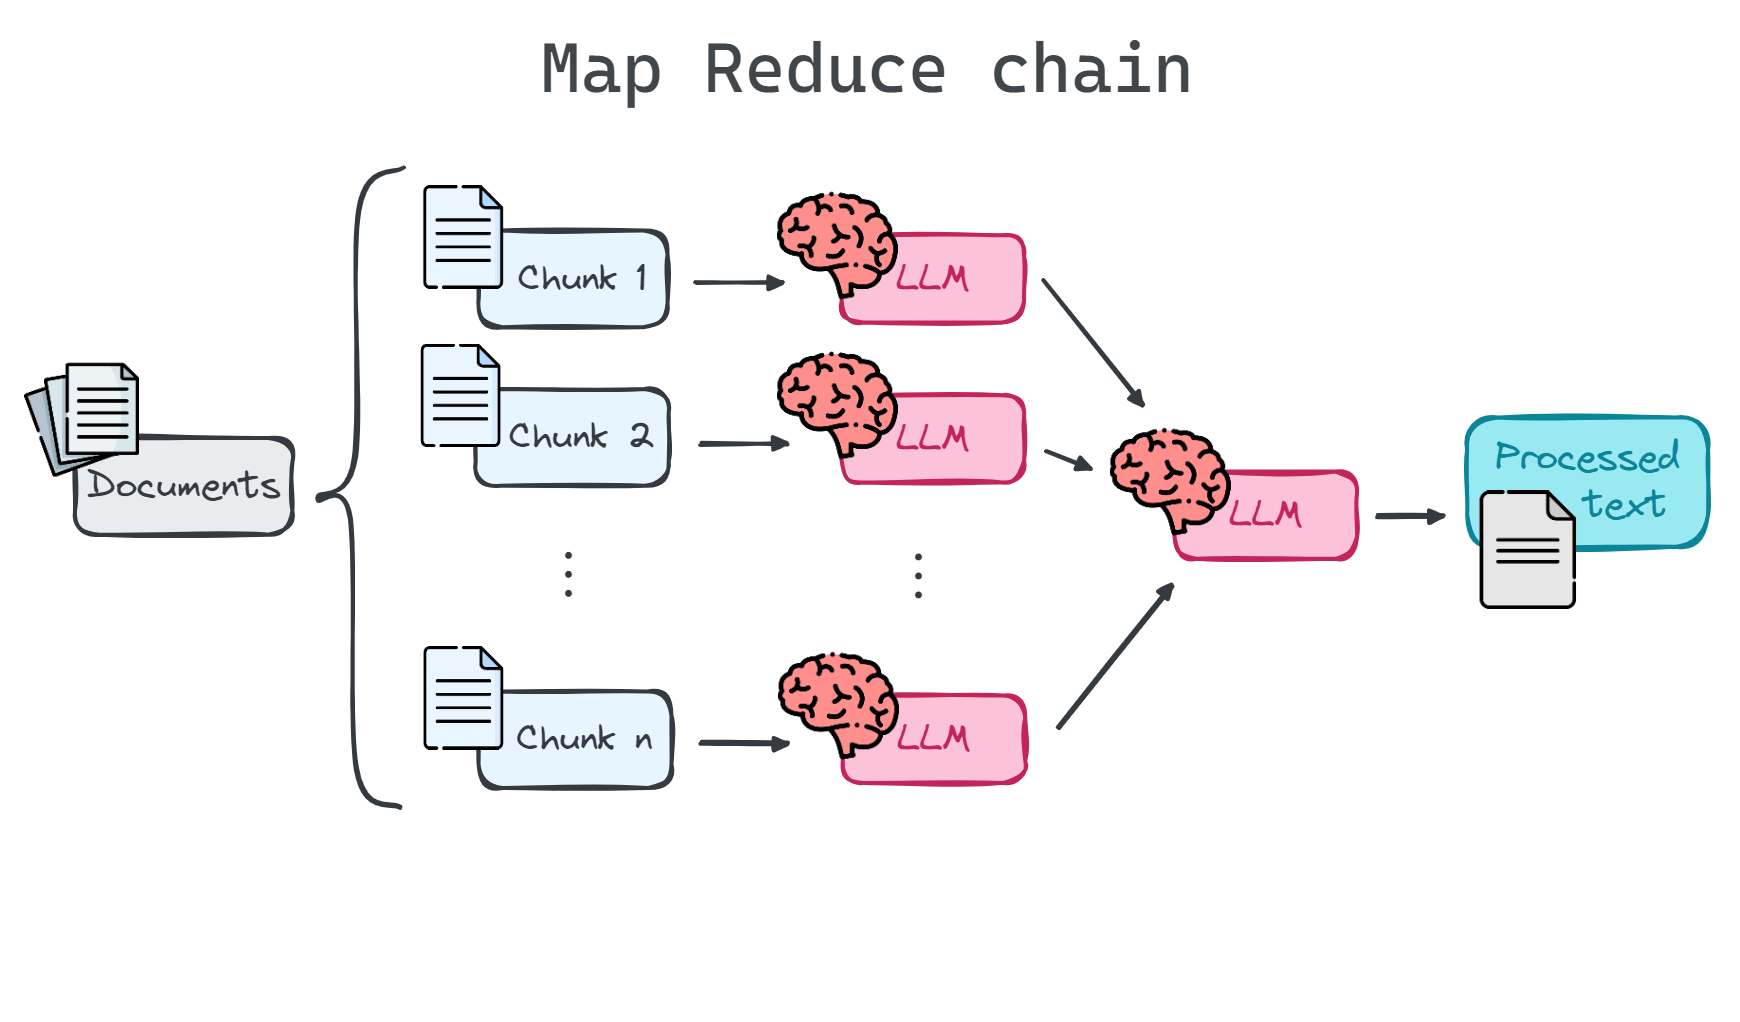

In [17]:
from IPython.display import Image, display
display(Image(filename="../../utils/images/map_reduce.png"))

In [18]:
# Traditional LangChain approach

# Map prompt - summarizes each document
map_template = "Write a concise summary of the following: {docs}"
map_prompt = ChatPromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=rag.llm, prompt=map_prompt)

# Reduce prompt - combines summaries and answers question
reduce_template = """The following is a set of summaries:
{docs}

Based on these summaries, answer the question: {question}"""
reduce_prompt = ChatPromptTemplate.from_template(reduce_template)
reduce_chain = LLMChain(llm=rag.llm, prompt=reduce_prompt)

# Combine documents chain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, 
    document_variable_name="docs"
)

# Reduce documents chain
reduce_documents_chain = ReduceDocumentsChain(
    combine_documents_chain=combine_documents_chain,
    collapse_documents_chain=combine_documents_chain,
    token_max=1000,
)

# Create the map-reduce chain
map_reduce_chain = MapReduceDocumentsChain(
    llm_chain=map_chain,
    reduce_documents_chain=reduce_documents_chain,
    document_variable_name="docs",
    return_intermediate_steps=False,
)

# Test the method
map_reduce_results = []
for test_query in test_queries:
    query = test_query["user_input"]
    docs = [doc[0] for doc in rag.retrieve_context(query)]
    result = map_reduce_chain.invoke({"input_documents": docs, "question": query})["output_text"]
    map_reduce_results.append({
        "question": query, 
        "answer": result, 
        "context": [{"content": doc.page_content} for doc in docs]
    })

# Evaluate
map_reduce_scores = evaluate_method("Map-Reduce Chain", map_reduce_results, ground_truths)


=== Map-Reduce Chain Results ===
Sample Answer: MC3G improves upon existing counterfactual explanation methods in two key ways regarding cost computation and causal dependencies:

1. **Accurate Cost Computation:**  Unlike previous methods that incl...
2025-09-16 18:15:39.711 INFO evaluation - evaluate_batch: 🔄 Evaluating 3 QA pairs...
2025-09-16 18:15:39.719 INFO evaluation - evaluate_batch: 🧮 Computing RAGAS metrics...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

2025-09-16 18:16:25.920 INFO evaluation - evaluate_batch: ✅ Evaluation completed
Average Faithfulness: 1.0
Average Answer Relevancy: 0.93


In [19]:
del map_template, map_prompt, map_chain, reduce_template, reduce_prompt, reduce_chain, combine_documents_chain, reduce_documents_chain, map_reduce_results#, map_reduce_chain

### 🔧 Map-Reduce Chain - LangGraph Implementation



=== Testing LangGraph Map-Reduce Implementation ===
LangGraph Result: MC3G improves upon existing counterfactual explanation methods like C3G and MACE in two key areas: cost computation and handling of causal dependencies.

**Cost Computation:**  Existing methods often ...


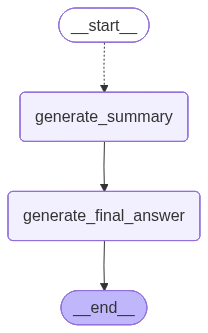

In [20]:
# LangGraph implementation
map_template_lg = "Write a concise summary of the following: {context}"
reduce_template_lg = """The following is a set of summaries:
{docs}

Based on these summaries, answer the question: {question}"""

map_prompt_lg = ChatPromptTemplate.from_template(map_template_lg)
reduce_prompt_lg = ChatPromptTemplate.from_template(reduce_template_lg)

# Create chains
map_chain_lg = map_prompt_lg | rag.llm | StrOutputParser()
reduce_chain_lg = reduce_prompt_lg | rag.llm | StrOutputParser()

# State definitions
class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    question: str
    final_answer: str

class SummaryState(TypedDict):
    content: str

# Generate summary for each document
def generate_summary(state: SummaryState):
    response = map_chain_lg.invoke({"context": state["content"]})
    return {"summaries": [response]}

# Map documents to summary nodes
def map_summaries(state: OverallState):
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]

# Generate final answer from summaries
def generate_final_answer(state: OverallState):
    response = reduce_chain_lg.invoke({
        "docs": "\n".join(state["summaries"]), 
        "question": state["question"]
    })
    return {"final_answer": response}

# Build graph
map_reduce_graph = StateGraph(OverallState)
map_reduce_graph.add_node("generate_summary", generate_summary)
map_reduce_graph.add_node("generate_final_answer", generate_final_answer)
map_reduce_graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
map_reduce_graph.add_edge("generate_summary", "generate_final_answer")
map_reduce_graph.add_edge("generate_final_answer", END)

map_reduce_app = map_reduce_graph.compile()

# Test LangGraph implementation
print("\n=== Testing LangGraph Map-Reduce Implementation ===")
query = test_queries[0]["user_input"]
docs = [doc[0] for doc in rag.retrieve_context(query)]

result = map_reduce_app.invoke({
    "contents": [doc.page_content for doc in docs],
    "question": query
})
print(f"LangGraph Result: {result['final_answer'][:200]}...")
Image(map_reduce_app.get_graph().draw_mermaid_png())

In [21]:
del map_template_lg, reduce_template_lg, map_prompt_lg, reduce_prompt_lg, map_chain_lg, reduce_chain_lg, map_reduce_graph, map_reduce_app, docs, result

## 📊 Method Comparison and Summary

Let's compare all methods side by side:


In [35]:
import pandas as pd

# Create comparison table
comparison_data = {
    'Method': ['Stuff Chain', 'Refine Chain', 'Map-Rerank Chain', 'Map-Reduce Chain'],
    'Faithfulness': [
        np.round(np.nanmean(stuff_scores['faithfulness']), 2),
        np.round(np.nanmean(refine_scores['faithfulness']), 2),
        np.round(np.nanmean(rerank_scores['faithfulness']), 2),
        np.round(np.nanmean(map_reduce_scores['faithfulness']), 2)
    ],
    'Answer Relevancy': [
        np.round(np.nanmean(stuff_scores['answer_relevancy']), 2),
        np.round(np.nanmean(refine_scores['answer_relevancy']), 2),
        np.round(np.nanmean(rerank_scores['answer_relevancy']), 2),
        np.round(np.nanmean(map_reduce_scores['answer_relevancy']), 2)
    ],
    'Best For': [
        'Small doc sets, simple queries',
        'Large doc sets, iterative refinement',
        'Confidence scoring, conflicting info',
        'Large doc sets, comprehensive answers'
    ],
    'Speed': ['Fastest', 'Slow', 'Medium', 'Slow'],
    'Context Window': ['Limited', 'Unlimited', 'Limited per doc', 'Unlimited']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n=== Method Comparison ===")
print(comparison_df.to_string(index=False))


=== Method Comparison ===
          Method  Faithfulness  Answer Relevancy                              Best For   Speed  Context Window
     Stuff Chain          1.00              0.95        Small doc sets, simple queries Fastest         Limited
    Refine Chain          0.92              0.86  Large doc sets, iterative refinement    Slow       Unlimited
Map-Rerank Chain          1.00              0.90  Confidence scoring, conflicting info  Medium Limited per doc
Map-Reduce Chain          1.00              0.93 Large doc sets, comprehensive answers    Slow       Unlimited


## 📌 Recommendations

### 🧩 Choose Your Method Based On:

1. **Document Count & Size:**
   - 📄 Few small documents → **Stuff Chain**
   - 📚 Many documents → **Refine Chain** or **Map-Reduce Chain**

2. **Information Quality:**
   - ⚖️ Conflicting information → **Map-Rerank Chain**
   - 🔀 Complementary information → **Map-Reduce Chain**

3. **Performance Requirements:**
   - ⚡ Speed critical → **Stuff Chain**
   - 🎯 Quality critical → **Refine Chain** or **Map-Reduce Chain**

4. **Special Needs:**
   - 📊 Need confidence scores → **Map-Rerank Chain**
   - 🔄 Need iterative improvement → **Refine Chain**
   - 🔀 Need comprehensive coverage → **Map-Reduce Chain**

### 🚀 Modern vs Traditional Approaches:

- 🔧 **LangGraph**: Better for complex workflows, debugging, and custom logic  
- ✅ **Traditional LangChain**: Simpler for standard use cases, less setup required


## 🧪 Experiment with Your Own Data

Use the code below to test different methods with your own queries:


In [23]:
def test_all_methods(query: str, show_context: bool = False):
    """Test all methods with a custom query."""
    print(f"\n=== Testing Query: {query} ===")
    
    # Get documents
    docs = [doc[0] for doc in rag.retrieve_context(query)]
    
    if show_context:
        print(f"\nRetrieved {len(docs)} documents")
        for i, doc in enumerate(docs[:2]):  # Show first 2
            print(f"Doc {i+1}: {doc.page_content[:100]}...")
    
    # Test each method
    methods = {
        "Stuff Chain": lambda: stuff_chain.invoke({"context": docs, "question": query}),
        "Refine Chain": lambda: refine_chain.invoke({"input_documents": docs, "question": query})["output_text"],
        "Map-Rerank Chain": lambda: rerank_chain.invoke({"input_documents": docs, "question": query})["output_text"],
        "Map-Reduce Chain": lambda: map_reduce_chain.invoke({"input_documents": docs, "question": query})["output_text"]
    }
    
    for method_name, method_func in methods.items():
        try:
            result = method_func()
            print(f"\n{method_name}: {result[:200]}...")
        except Exception as e:
            print(f"\n{method_name}: Error - {str(e)}")

# Example usage - uncomment to test
test_all_methods("What is the key innovation of the proposed Riemannian change point detection method?", show_context=True)



=== Testing Query: What is the key innovation of the proposed Riemannian change point detection method? ===

Retrieved 5 documents
Doc 1: 5 2 0 2

g u A 5 2

]

G L . s c [

1 v 5 4 0 8 1 . 8 0 5 2 : v i X r a

RIEMANNIAN CHANGE POINT DET...
Doc 2: [4] E. S. Page, “Continuous inspection schemes,” Biometrika, vol.

41, no. 1/2, pp. 100–115, 1954.

...

Stuff Chain: The key innovation of the proposed Riemannian change point detection method is the incorporation of robust centroid estimation using the Huber function from M-estimation theory.  This contrasts with p...

Refine Chain: The key innovation is a robust Riemannian change point detection (CPD) method that leverages M-estimation theory for centroid estimation, overcoming the sensitivity to outliers and distributional shif...

Map-Rerank Chain: The key innovation is online change point detection on Riemannian manifolds using Karcher mean estimates....

Map-Reduce Chain: The key innovation is the use of a robust centroid estimation 

## ✅ Conclusion

This tutorial demonstrated four different approaches to combining documents in RAG systems:

1. **Stuff Documents Chain** - 📄 Simple and fast for small document sets  
2. **Refine Documents Chain** - 🔄 Iterative improvement for large document sets  
3. **Map-Rerank Chain** - 📊 Confidence-based selection from individual documents  
4. **Map-Reduce Chain** - 🔀 Comprehensive approach for large, complementary document sets  

Each method has its strengths and is suitable for different scenarios. The choice depends on your specific requirements for speed, accuracy, document size, and information quality.

**Next Steps:**  
- 🧪 Experiment with different document types and sizes  
- 🔗 Try combining methods (e.g., Map-Rerank followed by Refine)  
- 📏 Implement custom evaluation metrics for your use case  
- 🎯 Explore advanced prompting techniques within each method  

**Key Takeaways:**  
- 📄 **Stuff Chain**: Best for simple cases with few documents  
- 🔄 **Refine Chain**: Best for iterative improvement with many documents  
- 📊 **Map-Rerank**: Best when you need confidence scores and document ranking  
- 🔀 **Map-Reduce**: Best for comprehensive analysis of large document sets  
- 🔧 **LangGraph**: Provides better control and debugging capabilities  
- ✅ **Traditional LangChain**: Simpler setup for standard use cases  


Images Reference: https://mlpills.substack.com/p/issue-71-langchains-text-processing